# Multi Instances Learning

In [5]:
%load_ext tensorboard
from helpers_image_pricecat import *
import os
from tqdm import tqdm
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.constraints import maxnorm
from sklearn.model_selection import train_test_split
import pandas as pd
tf.compat.v1.enable_eager_execution()


# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [21]:
resnet = keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', pooling="avg", input_shape = (None, None, 3))
resnet.trainable = False

def make_features(names, folder = "data/images_resized"):
    path = [folder+"/"+x for x in names]
    imgs = []
    for i in path:
        img_tmp = plt.imread(i)
        img_tmp = np.expand_dims(img_tmp, axis = 0)
        img_tmp = keras.applications.resnet50.preprocess_input(img_tmp)
        feat_tmp = resnet(img_tmp)
        imgs.append(feat_tmp)
    imgs = np.stack(imgs)
    bag_features = tf.reduce_mean(imgs, axis = 0)
    return bag_features


In [22]:
img_folder = "data/images_resized"
img_df = pd.read_csv("data/img_paths.csv")
img_df = img_df[img_df["label"] == 4]
img_df

,img_path,id,img_no,label
0,44077_0.png,44077,0,4.0
43,85148_7.png,85148,7,4.0
48,85156_0.png,85156,0,4.0
96,159889_10.png,159889,10,4.0
98,159889_12.png,159889,12,4.0
...,...,...,...,...
86410,53152026_8.png,53152026,8,4.0
86411,53152026_9.png,53152026,9,4.0
86413,53152026_11.png,53152026,11,4.0
86415,53152026_13.png,53152026,13,4.0


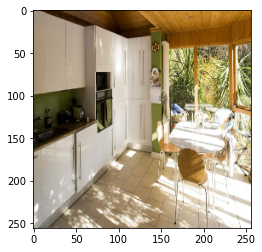

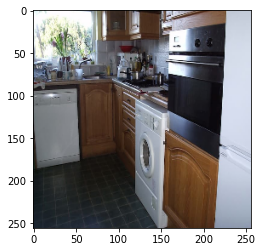

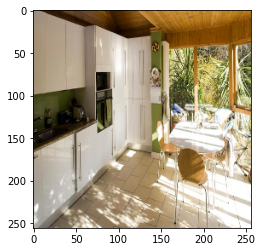

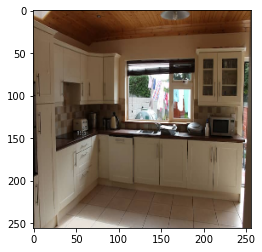

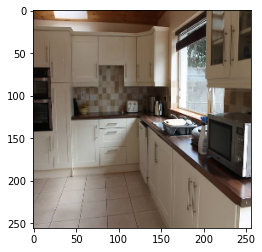

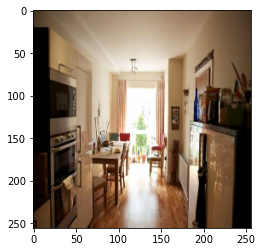

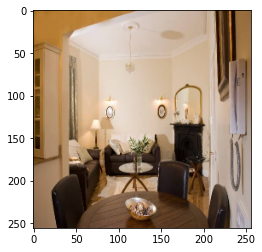

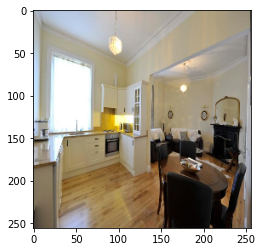

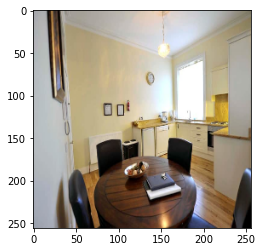

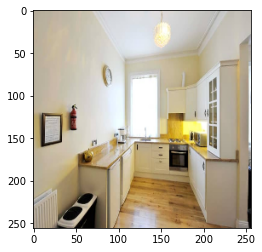

In [23]:
for i in img_df["img_path"][:10]:
    img = plt.imread("data/images_resized/"+i)
    plt.imshow(img)
    plt.show()


In [24]:
# LOAD DATA 
url_listing = "http://data.insideairbnb.com/ireland/leinster/dublin/2021-11-07/data/listings.csv.gz"
listings = pd.read_csv(url_listing)
urls = listings["listing_url"]
ids = listings["id"]
price = listings["price"]
price = price.str.replace("$","")
price = price.str.replace(",","")
price = price.astype(float)
price = pd.DataFrame(price)
price["log_price"] = np.log(price)
price["id"] = listings["id"]
price = price[["id", "price", "log_price"]]


# MAKE PRICE CATEGORIES
# form size dependent groups
listings["size_group"] = listings["accommodates"].astype(str)

# consider all listings that are for more than 6 people as one group
filter = listings["accommodates"] > 8
listings["size_group"][filter] = "greater 8"

# construct new column that is basically the price of the listing. Only correct the price for the group >6 by dividing by accommodates
listings["price_adj"] = price["log_price"]
listings["price_adj"][filter] = (price["price"]/listings["accommodates"])[filter]

# find the group specific quantiles
quantiles = listings.groupby(listings["size_group"]).quantile([0,0.05,0.25,0.75,0.95,1])["price_adj"]

# construct new column that gives the price category in the groups by taking the group quantiles into account
listings["price_category"] = np.repeat(None, len(listings))
for size_gr in np.unique(listings["size_group"]):
    filter = listings["size_group"] == size_gr
    q = quantiles[size_gr]
    # adjust lower and upper bound
    q[0] = q[0]-1
    q[1] = q[1]+1
    listings["price_category"][filter] = pd.cut(listings["price_adj"][filter], bins = q, labels = ["very cheap", "cheap", "middle", "expensive", "very expensive"])

from sklearn import preprocessing
# store label in one column
le = preprocessing.LabelEncoder()
le.fit(listings["price_category"])
listings["price_category_label"] = le.transform(listings["price_category"])

/var/folders/97/j215pw6x7sq158bvx1ktlhf80000gn/T/ipykernel_4526/2923718438.py:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  price = price.str.replace("$","")
/var/folders/97/j215pw6x7sq158bvx1ktlhf80000gn/T/ipykernel_4526/2923718438.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings["size_group"][filter] = "greater 8"
/var/folders/97/j215pw6x7sq158bvx1ktlhf80000gn/T/ipykernel_4526/2923718438.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listin

In [25]:
img_df

,img_path,id,img_no,label
0,44077_0.png,44077,0,4.0
43,85148_7.png,85148,7,4.0
48,85156_0.png,85156,0,4.0
96,159889_10.png,159889,10,4.0
98,159889_12.png,159889,12,4.0
...,...,...,...,...
86410,53152026_8.png,53152026,8,4.0
86411,53152026_9.png,53152026,9,4.0
86413,53152026_11.png,53152026,11,4.0
86415,53152026_13.png,53152026,13,4.0


In [26]:
# ids = np.unique(img_df["id"])
# bag_features_bedroom = []
# bag_features_bathroom = []
# price_cat = []
# for id in tqdm(ids):
#     # Get features for id
#     filter = img_df["id"] == id
#     names = img_df["img_path"][filter]
#     filter2 = img_df["label"] == 0
#     filter3 = img_df["label"] == 1
  
#     names_bath = img_df["img_path"][filter+filter2]
#     names_bed = img_df["img_path"][filter+filter3]

#     bag_features_bathroom.append(make_features(names_bath))
#     bag_features_bedroom.append(make_features(names_bed))
    
#     # Get price for id
#     filter = listings["id"] == id
#     price_cat_tmp = listings["price_category_label"][filter].values[0]
#     price_cat.append(price_cat_tmp)
    
# bag_features_bathroom = np.stack(bag_features_bathroom)
# bag_features_bedroom = np.stack(bag_features_bedroom)

# price_cat = np.stack(price_cat)

# np.save("data/bag_features_bedroom.npy", bag_features_bedroom)
# np.save("data/bag_features_bathroom.npy", bag_features_bathroom)

# np.save("data/price_cat.npy", price_cat)
# np.save("data/ids.npy", ids)

In [27]:
ids = np.unique(img_df["id"])
bag_features = []
price_cat = []

for id in tqdm(ids):
    # Get features for id
    filter = img_df["id"] == id
    names = img_df["img_path"][filter]
    bag_features.append(make_features(names))
    
    # Get price for id
    filter = listings["id"] == id
    price_cat_tmp = listings["price_category_label"][filter].values[0]
    price_cat.append(price_cat_tmp)
    
bag_features = np.stack(bag_features)
price_cat = np.stack(price_cat)

np.save("data/bag_features_kitchen.npy", bag_features)

np.save("data/price_cat_kitchen.npy", price_cat)
np.save("data/ids_kitchen.npy", ids)

100%|██████████| 5072/5072 [09:45<00:00,  8.66it/s]


In [15]:
bag_features = np.load("data/bag_features.npy")
price_cat = np.load("data/price_cat.npy")

In [28]:
weights = 1/(pd.Series(price_cat).value_counts()/len(price_cat))
weights = weights.to_dict()
weights

{2: 2.024750499001996,
 0: 4.9147286821705425,
 1: 5.097487437185929,
 3: 18.785185185185185,
 4: 18.785185185185185}

In [29]:
bag_features = np.squeeze(bag_features)

In [30]:
# check for noninformative features
filter = np.nonzero(bag_features.sum(axis = 0))[0]
bag_features = bag_features[:,filter]
print(len(filter), " features are nonzero.")

# split data
X_train, X_test, y_train, y_test = train_test_split(bag_features, price_cat, test_size=0.2, random_state=1)

X_train = tf.convert_to_tensor(X_train, dtype = tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype = tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype = tf.int64)
y_test = tf.convert_to_tensor(y_test, dtype = tf.int64)


# # standardize data
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

1501  features are nonzero.


In [31]:
class Images_pricecat(tf.keras.Model):

  def __init__(self):
    super().__init__()
    self.bn1 = tf.keras.layers.BatchNormalization()
    self.drop1 = tf.keras.layers.Dropout(0.2)
    self.dense1 = tf.keras.layers.Dense(1024, activation=tf.nn.relu, kernel_regularizer = keras.regularizers.l2(0.1))
    
    self.bn2 = tf.keras.layers.BatchNormalization()
    self.drop2 = tf.keras.layers.Dropout(0.2)
    self.dense2 = tf.keras.layers.Dense(512, activation=tf.nn.relu, kernel_regularizer = keras.regularizers.l2(0.1))
    
    self.dense3 = tf.keras.layers.Dense(5, activation=tf.nn.softmax)

  def call(self, inputs):
    x = self.bn1(inputs)
    x = self.drop1(x)
    x = self.dense1(x)
    
    x = self.bn2(inputs)
    x = self.drop2(x)
    x = self.dense2(x)
    
    return self.dense3(x)

In [34]:
# train model
model = Images_pricecat()
model.compile(optimizer=keras.optimizers.Adam(lr= 0.0001),
                loss= keras.losses.SparseCategoricalCrossentropy(from_logits = False), metrics=["accuracy"])
model.fit(x = X_train, y = y_train, batch_size = 64, epochs = 500, validation_data = (X_test, y_test), class_weight = weights)

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/500


2022-02-02 16:55:24.429487: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


64/64 [==============================] - ETA: 0s - loss: 175.6288 - accuracy: 0.2142

2022-02-02 16:55:27.215613: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


64/64 [==============================] - 4s 44ms/step - loss: 175.6288 - accuracy: 0.2142 - val_loss: 140.9114 - val_accuracy: 0.0640
Epoch 2/500
64/64 [==============================] - 2s 35ms/step - loss: 125.0520 - accuracy: 0.2453 - val_loss: 99.1145 - val_accuracy: 0.0532
Epoch 3/500
64/64 [==============================] - 2s 32ms/step - loss: 89.7756 - accuracy: 0.2571 - val_loss: 69.9416 - val_accuracy: 0.0542
Epoch 4/500
64/64 [==============================] - 2s 32ms/step - loss: 65.1705 - accuracy: 0.2734 - val_loss: 49.6839 - val_accuracy: 0.0640
Epoch 5/500
64/64 [==============================] - 2s 32ms/step - loss: 48.1377 - accuracy: 0.2746 - val_loss: 35.7484 - val_accuracy: 0.0975
Epoch 6/500
64/64 [==============================] - 2s 32ms/step - loss: 36.4230 - accuracy: 0.2837 - val_loss: 26.2463 - val_accuracy: 0.1724
Epoch 7/500
64/64 [==============================] - 2s 34ms/step - loss: 28.4853 - accuracy: 0.3111 - val_loss: 19.8007 - val_accuracy: 0.2374
E

2022-02-02 15:03:40.480400: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


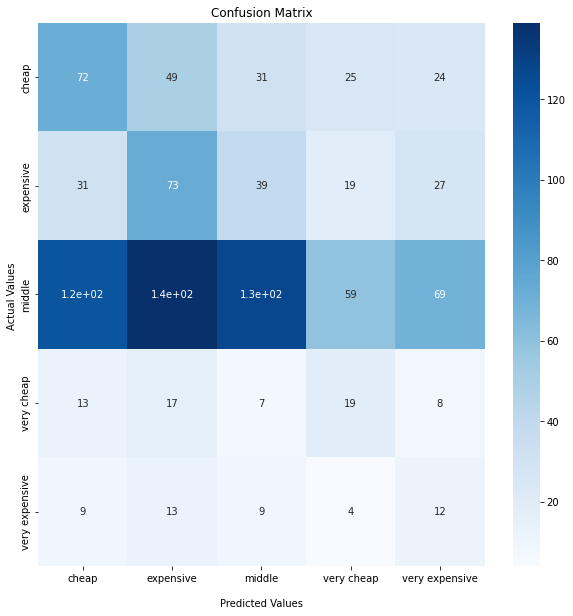

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,10))
y_pred = np.argmax(model.predict(X_test), axis = 1)
cf_matrix = confusion_matrix(y_test, y_pred)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(le.inverse_transform(np.array([0,1,2,3,4])))
ax.yaxis.set_ticklabels(le.inverse_transform(np.array([0,1,2,3,4])))

## Display the visualization of the Confusion Matrix.
plt.show()

# Without bags

In [83]:
resnet = keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', pooling="avg", input_shape = (None, None, 3))
resnet.trainable = False

def make_features(names, folder = "data/images_resized"):
    path = [folder+"/"+x for x in names]
    imgs = []
    for i in path:
        imgs.append(plt.imread(i))
    imgs = np.stack(imgs)
    imgs = keras.applications.resnet50.preprocess_input(imgs)
    features = resnet(imgs)
    bag_features = tf.reduce_max(features, axis = 0)
    return bag_features


In [84]:
img_folder = "data/images_resized"
img_df = pd.read_csv("data/img_paths.csv")
img_df = img_df[img_df["label"] == 0]
img_df

,img_path,id,img_no,label
10,44077_10.png,44077,10,0.0
45,85148_9.png,85148,9,0.0
47,85148_11.png,85148,11,0.0
60,85156_12.png,85156,12,0.0
61,85156_13.png,85156,13,0.0
...,...,...,...,...
86397,53140691_9.png,53140691,9,0.0
86398,53140691_10.png,53140691,10,0.0
86417,53152026_15.png,53152026,15,0.0
86418,53152026_16.png,53152026,16,0.0


In [85]:
# LOAD DATA 
url_listing = "http://data.insideairbnb.com/ireland/leinster/dublin/2021-11-07/data/listings.csv.gz"
listings = pd.read_csv(url_listing)
urls = listings["listing_url"]
ids = listings["id"]
price = listings["price"]
price = price.str.replace("$","")
price = price.str.replace(",","")
price = price.astype(float)
price = pd.DataFrame(price)
price["log_price"] = np.log(price)
price["id"] = listings["id"]
price = price[["id", "price", "log_price"]]


# MAKE PRICE CATEGORIES
# form size dependent groups
listings["size_group"] = listings["accommodates"].astype(str)

# consider all listings that are for more than 6 people as one group
filter = listings["accommodates"] > 8
listings["size_group"][filter] = "greater 8"

# construct new column that is basically the price of the listing. Only correct the price for the group >6 by dividing by accommodates
listings["price_adj"] = price["log_price"]
listings["price_adj"][filter] = (price["price"]/listings["accommodates"])[filter]

# find the group specific quantiles
quantiles = listings.groupby(listings["size_group"]).quantile([0,0.05,0.25,0.75,0.95,1])["price_adj"]

# construct new column that gives the price category in the groups by taking the group quantiles into account
listings["price_category"] = np.repeat(None, len(listings))
for size_gr in np.unique(listings["size_group"]):
    filter = listings["size_group"] == size_gr
    q = quantiles[size_gr]
    # adjust lower and upper bound
    q[0] = q[0]-1
    q[1] = q[1]+1
    listings["price_category"][filter] = pd.cut(listings["price_adj"][filter], bins = q, labels = ["very cheap", "cheap", "middle", "expensive", "very expensive"])

from sklearn import preprocessing
# store label in one column
le = preprocessing.LabelEncoder()
le.fit(listings["price_category"])
listings["price_category_label"] = le.transform(listings["price_category"])

/var/folders/97/j215pw6x7sq158bvx1ktlhf80000gn/T/ipykernel_1410/2923718438.py:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  price = price.str.replace("$","")
/var/folders/97/j215pw6x7sq158bvx1ktlhf80000gn/T/ipykernel_1410/2923718438.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings["size_group"][filter] = "greater 8"
/var/folders/97/j215pw6x7sq158bvx1ktlhf80000gn/T/ipykernel_1410/2923718438.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listin

In [86]:
img_df = img_df.reset_index()
img_df

,index,img_path,id,img_no,label
0,10,44077_10.png,44077,10,0.0
1,45,85148_9.png,85148,9,0.0
2,47,85148_11.png,85148,11,0.0
3,60,85156_12.png,85156,12,0.0
4,61,85156_13.png,85156,13,0.0
...,...,...,...,...,...
11157,86397,53140691_9.png,53140691,9,0.0
11158,86398,53140691_10.png,53140691,10,0.0
11159,86417,53152026_15.png,53152026,15,0.0
11160,86418,53152026_16.png,53152026,16,0.0


In [87]:
img_df

,index,img_path,id,img_no,label
0,10,44077_10.png,44077,10,0.0
1,45,85148_9.png,85148,9,0.0
2,47,85148_11.png,85148,11,0.0
3,60,85156_12.png,85156,12,0.0
4,61,85156_13.png,85156,13,0.0
...,...,...,...,...,...
11157,86397,53140691_9.png,53140691,9,0.0
11158,86398,53140691_10.png,53140691,10,0.0
11159,86417,53152026_15.png,53152026,15,0.0
11160,86418,53152026_16.png,53152026,16,0.0


In [68]:
listings

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,size_group,price_adj,price_category,price_category_label
0,44077,https://www.airbnb.com/rooms/44077,20211107161700,2021-11-08,cosy comfortable Irish cottage twin,Our house was built in 1937 when there was ple...,I like our neighbourhood as there is no shorta...,https://a0.muscache.com/pictures/525706/050a3a...,193005,https://www.airbnb.com/users/show/193005,...,f,3,0,3,0,1.82,2,4.174387,middle,2
1,85148,https://www.airbnb.com/rooms/85148,20211107161700,2021-11-08,Habitación en Dublín Double room,<b>The space</b><br />I'm renting a double roo...,NaN,https://a0.muscache.com/pictures/583752/61c664...,466111,https://www.airbnb.com/users/show/466111,...,f,1,0,1,0,0.03,2,3.401197,very cheap,3
2,85156,https://www.airbnb.com/rooms/85156,20211107161700,2021-11-08,Cosy Comfortable Irish Cottage 1 Double Bed,Our Cottage is a charming light filled cottage...,"I love Dundrum and its surrounding areas ,<br ...",https://a0.muscache.com/pictures/1749253/9ed2a...,193005,https://www.airbnb.com/users/show/193005,...,f,3,0,3,0,2.15,2,4.143135,middle,2
3,159889,https://www.airbnb.com/rooms/159889,20211107161700,2021-11-08,Friendly Single Room,Washing can be done at a cost of €5 per load....,Plenty of buses into the city and the area is ...,https://a0.muscache.com/pictures/3031697/a8259...,766611,https://www.airbnb.com/users/show/766611,...,t,3,0,3,0,3.44,1,3.806662,middle,2
4,162809,https://www.airbnb.com/rooms/162809,20211107161700,2021-11-08,5.5 miles south of Dublin City :^),A nice place to relax after the bustle of the ...,"Close to the sea, hill walks and the city - vi...",https://a0.muscache.com/pictures/86694529/c07b...,777681,https://www.airbnb.com/users/show/777681,...,f,2,0,2,0,3.75,6,4.174387,very cheap,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6971,53159314,https://www.airbnb.com/rooms/53159314,20211107161700,2021-11-08,Stylish 1 bed in Dublin 4 close to all amenities,The apartment is located within a stunning Geo...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,430187374,https://www.airbnb.com/users/show/430187374,...,f,7,7,0,0,NaN,2,4.867534,expensive,1
6972,53160612,https://www.airbnb.com/rooms/53160612,20211107161700,2021-11-08,Lovely non shared single bedroom,We are a very easy going couple. The apartment...,NaN,https://a0.muscache.com/pictures/e51dc18d-d94e...,56973664,https://www.airbnb.com/users/show/56973664,...,f,1,0,1,0,NaN,1,3.828641,middle,2
6973,53177641,https://www.airbnb.com/rooms/53177641,20211107161700,2021-11-08,Adorable 1 bedroom and 1 bathroom apartment.,"This large, newly refurbished apartment is wit...",NaN,https://a0.muscache.com/pictures/miso/Hosting-...,430187374,https://www.airbnb.com/users/show/430187374,...,f,7,7,0,0,NaN,2,4.867534,expensive,1
6974,53178928,https://www.airbnb.com/rooms/53178928,20211107161700,2021-11-08,Lovely 1 bed apartment in a ideally location.,"This bright, newly refurbished apartment is wi...",NaN,https://a0.muscache.com/pictures/a07ebe59-e452...,430187374,https://www.airbnb.com/users/show/430187374,...,t,7,7,0,0,NaN,2,4.867534,expensive,1


In [69]:
resnet = keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', pooling="avg", input_shape = (None, None, 3))
resnet.trainable = False

def make_single_features(names, folder = "data/images_resized"):
    
    path = folder+"/"+names

    img = plt.imread(path)
    img = np.expand_dims(img, axis = 0)    

    img = keras.applications.resnet50.preprocess_input(img)
    features = resnet(img)
    return features

In [70]:
images = []
price_cat = []
for i in tqdm(range(len(img_df))):
    # Get features for id
    id = img_df["id"][i]

    names = img_df["img_path"][i]
    images.append(make_single_features(names))

    # Get price for id
    filter = listings["id"] == id
    price_cat_tmp = listings["price_category_label"][filter].values[0]
    price_cat.append(price_cat_tmp)
    
images = np.stack(images)
price_cat = np.stack(price_cat)

#np.save("data/bath_img.npy", images)
#np.save("data/bath_price.npy", price_cat)

100%|██████████| 11162/11162 [06:17<00:00, 29.59it/s]


In [71]:
weights = 1/(pd.Series(price_cat).value_counts()/len(price_cat))
weights = weights.to_dict()
weights

{2: 2.0,
 1: 4.821598272138229,
 0: 4.969723953695459,
 4: 21.383141762452105,
 3: 22.413654618473895}

In [75]:
# check for noninformative features
#filter = np.all((images == 0), axis=1)
#images = images[~filter]

# split data
X_train, X_test, y_train, y_test = train_test_split(images, price_cat, test_size=0.2, random_state=1)

X_train = tf.convert_to_tensor(X_train, dtype = tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype = tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype = tf.int64)
y_test = tf.convert_to_tensor(y_test, dtype = tf.int64)


# # standardize data
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

In [73]:
class Images_pricecat(tf.keras.Model):

  def __init__(self):
    super().__init__()
    self.bn1 = tf.keras.layers.BatchNormalization()
    self.drop = tf.keras.layers.Dropout(0.5)
    self.dense1 = tf.keras.layers.Dense(512, activation=tf.nn.relu, kernel_regularizer = keras.regularizers.l2(0.01))
    self.dense2 = tf.keras.layers.Dense(5, activation=tf.nn.softmax)

  def call(self, inputs):
    x = self.bn1(inputs)
    x = self.drop(x)
    x = self.dense1(x)
    return self.dense2(x)

In [74]:
# train model
model = Images_pricecat()
model.compile(optimizer=keras.optimizers.Adam(lr= 0.0001),
                loss= keras.losses.SparseCategoricalCrossentropy(from_logits = False), metrics=["accuracy"])
model.fit(x = X_train, y = y_train, batch_size = 256, epochs = 500, validation_data = (X_test, y_test), class_weight = weights)

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/500


2022-02-01 18:45:56.644143: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


35/35 [==============================] - 1s 24ms/step - loss: 16.1864 - accuracy: 0.0973 - val_loss: 9.1399 - val_accuracy: 0.0448
Epoch 2/500
 1/35 [..............................] - ETA: 0s - loss: 16.5793 - accuracy: 0.1328

2022-02-01 18:45:57.542044: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


35/35 [==============================] - 1s 20ms/step - loss: 14.7652 - accuracy: 0.1806 - val_loss: 8.0508 - val_accuracy: 0.0448
Epoch 3/500
35/35 [==============================] - 1s 20ms/step - loss: 13.7755 - accuracy: 0.2177 - val_loss: 7.1691 - val_accuracy: 0.0452
Epoch 4/500
35/35 [==============================] - 1s 21ms/step - loss: 12.9926 - accuracy: 0.2273 - val_loss: 6.4939 - val_accuracy: 0.0461
Epoch 5/500
35/35 [==============================] - 1s 20ms/step - loss: 12.3786 - accuracy: 0.2261 - val_loss: 5.9198 - val_accuracy: 0.0511
Epoch 6/500
35/35 [==============================] - 1s 20ms/step - loss: 11.8249 - accuracy: 0.2313 - val_loss: 5.4475 - val_accuracy: 0.0582
Epoch 7/500
35/35 [==============================] - 1s 20ms/step - loss: 11.3864 - accuracy: 0.2417 - val_loss: 5.0581 - val_accuracy: 0.0833
Epoch 8/500
35/35 [==============================] - 1s 20ms/step - loss: 10.9995 - accuracy: 0.2484 - val_loss: 4.7410 - val_accuracy: 0.1146
Epoch 9/500

In [90]:
model.predict(X_test).shape

(2233, 1, 5)

In [91]:
y_pred = np.argmax(np.squeeze(model.predict(X_test)), axis = 1)
y_pred

array([4, 0, 0, ..., 0, 2, 0])

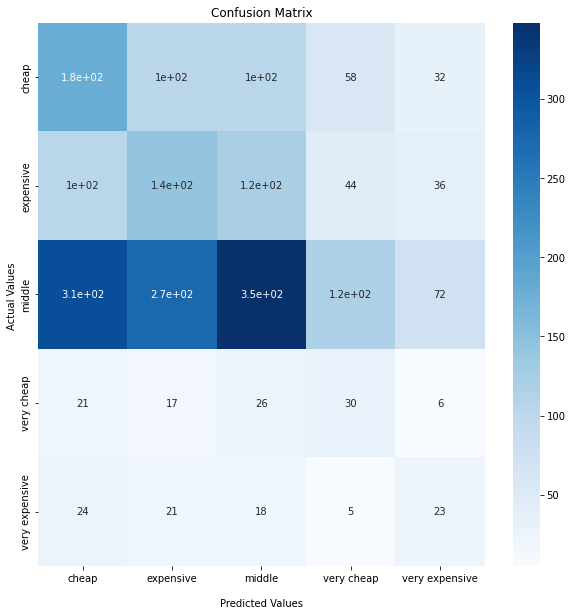

In [92]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,10))
y_pred = np.argmax(np.squeeze(model.predict(X_test)), axis = 1)
cf_matrix = confusion_matrix(y_test, y_pred)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(le.inverse_transform(np.array([0,1,2,3,4])))
ax.yaxis.set_ticklabels(le.inverse_transform(np.array([0,1,2,3,4])))

## Display the visualization of the Confusion Matrix.
plt.show()